# Analyse d'une plateforme qui organise des "speed dating"

## Projet Python - 2A - ENSAE 2022/2023

#### Arthur Sabre - Baptiste Ferrere - Oscar Legoupil

## Introduction

Avec le confinement, les applications et sites de rencontres connaissent un essor fulgurant. En 2020, la célèbre application Tinder ne compte pas moins de 270 millions d’utilisateurs. Aussi, il y a un grand nombre d’applications de rencontres de toutes sortes sur le marché qui proposent (ou non) autant d’options diverses et variées en prenant en compte un nombre infini de caractéristiques propres aux utilisateurs. 
Bien évidemment, par soucis de confidentialité il est extrêmement difficile, voire impossible, d’obtenir des données récentes sur des applications de rencontres modernes comme Tinder. Ainsi, nous avons décidé de travailler sur une base de données assez vieille mais qui collecte assez de paramètres concernant un assez grand nombre d’utilisateurs pour que l’on puisse en tirer quelque chose. La base de données concerne une application qui organise des « speed dating » (rendez-vous rapides) entre deux personnes de sexes opposés et en fonction des caractéristiques et des goûts de chacun, ils décident ou non de se revoir lors d’un « date ».
La problématique générale des utilisateurs de cette application est la même : « trouver l’amour » ou en pratique, avoir un « date », c’est-à-dire qu’à l’issu d’une analyse réciproque des caractéristiques des individus, ils choisissent à la fin de se revoir ou non. Ainsi, on modélisera les individus par l’ensemble de leurs caractéristiques personnelles présentes dans notre base de données et on identifiera la « réussite » par le fait que les deux individus veuillent se revoir lors d’un date.


## Problématiques 

L'application étudiée propose-t-elle des résultats concluants ?

Quelles sont les caractéristiques qui rentrent en jeu lors de la décision finale ?

## Importations

Nous allons travailler sur une base de données en format CSV sur laquelle nous allons réaliser différents statistiques, graphiques etc..
Ainsi, l'importation de certaines librairies comme Pandas est nécessaire.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

## I - Traitement de la base de données

### Lecture et nettoyage de la base de données

On a d'abord récupéré la base de donnée brute 'speeddating.csv' sur laquelle on a réalisé plusieurs modifications : correction des fautes d'orthographes, changement de noms de variables pour avoir des noms plus cohérents,...

In [2]:
df = pd.read_csv('data/speeddating.csv')
df2 = df.copy()

In [3]:
df2.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,decision,decision_o,match
0,0,1,female,21.0,27.0,6,[4-6],asian/pacific islander/asian-american,european/caucasian-american,0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,0,0
1,0,1,female,21.0,22.0,1,[0-1],asian/pacific islander/asian-american,european/caucasian-american,0,...,[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,1,0,0
2,1,1,female,21.0,22.0,1,[0-1],asian/pacific islander/asian-american,asian/pacific islander/asian-american,1,...,[0-3],[3-5],7.0,NaN,[6-8],[0-4],1.0,1,1,1
3,0,1,female,21.0,23.0,2,[2-3],asian/pacific islander/asian-american,european/caucasian-american,0,...,[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1,1,1
4,0,1,female,21.0,24.0,3,[2-3],asian/pacific islander/asian-american,latino/hispanic american,0,...,[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1,1,1


On supprime les variables commençant par 'd_' car elles ne nous intéressent pas pour la suite de l'analyse.

In [4]:
# Suppression de variables

for col in df2.columns:
    if bool(re.search("^(d_).+", col)):
        del df2[col]

In [5]:
# Correction de fautes

df2.rename(columns = {'ambtition_important':'ambition_important',
                     'intellicence_important':'intelligence_important',
                     'samerace':'same_race',
                     'sinsere':'sincere',
                     'sinsere_o':'sincere_o',
                     'ambitous_o':'ambition_o',
                     'intellicence_important':'intelligence_important'}, inplace = True)

In [6]:
# Renommage de certaines variables

df2.rename(columns = {'pref_o_attractive': 'attractive_important_o',
                      'pref_o_sincere': 'sincere_important_o',
                      'pref_o_intelligence': 'intelligence_important_o',
                      'pref_o_funny': 'funny_important_o',
                      'pref_o_ambitious': 'ambition_important_o',
                      'pref_o_shared_interests': 'shared_interests_important_o',
                      'd_pref_o_attractive': 'd_attractive_important_o',
                      'd_pref_o_sincere': 'd_sincere_important_o',
                      'd_pref_o_intelligence': 'd_intelligence_important_o',
                      'd_pref_o_funny': 'd_funny_important_o',
                      'd_pref_o_ambitious': 'd_ambition_important_o',
                      'd_pref_o_shared_interests': 'd_shared_interests_important_o'}, inplace = True)

Ensuite, on doit créer notre variable 'id' pour pouvoir identifier les individus. Pour cela, on regarde le maximum de caractéristiques personnelles qui ne changent pas par ligne dans une vague (âge, notes de soi mêmes, préférences personnelles, etc...) On indentifie ensuite un individu à ce vecteur de toutes ces caractéristiques. Ainsi, les individus ayant exactement toutes ces mêmes caractéristiques seront considérés comme identiques dans notre modèle et auront le même identifiant (de plus, si dans la vie réelle ils étaient différents, cela ne poserait pas de problème pour deux raisons : premièrement la probabilité qu'ils soient différents est extrêmement faible au vu du nombre de caractéristiques considérés et s'ils diffèrent, c'est sur une caractéristique non présente dans notre modèle).

In [7]:
invariants = ['gender', 'age', 'race', 'importance_same_race', 'importance_same_religion', 'field', 'attractive_important', 'sincere_important', 'intelligence_important', 'funny_important', 'ambition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga'] 

In [8]:
# Création d'une colonne id
df2.loc[0, 'id'] = 1 

In [9]:
# On vérifie s'il y a beaucoup de valeurs manquantes pour créer l'identifiant
df2[invariants].isna().any(axis=1).sum()

169

In [10]:
df2 = df2.dropna(subset=invariants) # Suppression des  lignes contenant des valeurs manquantes
df2 = df2.reset_index() # Réindexation du dataframe
del df2['index']

In [11]:
# Remplissage de la colonne id

id=0
caracteristiques = df2.loc[0, invariants]
for i in range (len(df2)):
    if (caracteristiques == df2.loc[i, invariants]).sum() < len(invariants): # invariants non vérifiés
        caracteristiques = df2.loc[i, invariants]
        id += 1
        df2.loc[i, 'id'] = id
    else:
        df2.loc[i, 'id'] = id

In [12]:
# Insérer la colonne 'id' au début du tableau

id = df2[['id']]
del df2['id']
df2.insert(0, 'id', id)
df2['id'] = df2['id'].astype(int)

On crée ensuite un tableau ne concernant que les caractéristiques propres à chaque individu

In [13]:
df_personal = pd.DataFrame([], columns = invariants)
df_personal.insert(0, 'id', [])

In [14]:
# Création d'un dataframe contenant les infos personnelles uniquement des candidats

for id in range(0,538):
    indiv = df2.loc[df2['id'] == id] # Récupère les lignes concernant l'individu i
    carac = indiv.head(1)[invariants] # Récupère les invariants de l'individu identifié i
    df_personal = pd.concat([df_personal, carac]) # Ajout de la ligne à df_personal
    df_personal.iloc[id, 0] = id
df_personal['id'] = df_personal['id'].astype(int)
df_personal = df_personal.reset_index()
del df_personal['index']

Enfin, on a créé toutes les variables qui nous paraissaient nécessaires pour avancer dans la suite de notre projet.

In [15]:
# Ajout de note_moyenne et note_moyenne_o dans la grosse BDD

df2['note_moyenne'] = 1/100 * (df2['attractive_important']*df2['attractive'] + df2['sincere_important']*df2['sincere'] + 
                               df2['intelligence_important']*df2['intelligence'] + df2['funny']*df2['funny'] + 
                               df2['ambition_important']*df2['ambition'])

df2['note_moyenne_o'] = 1/100 * (df2['attractive_important_o']*df2['attractive_o'] + df2['sincere_important_o']*df2['sincere_o'] + 
                                 df2['intelligence_important_o']*df2['intelligence_o'] + df2['funny_important_o']*df2['funny_o'] + 
                                 df2['ambition_important_o']*df2['ambition_o'])

In [16]:
df2.head()

,id,has_null,wave,gender,age,age_o,race,race_o,same_race,importance_same_race,...,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,decision,decision_o,match,note_moyenne,note_moyenne_o
0,0,0,1,female,21.0,27.0,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,...,2.0,4.0,7.0,6.0,0.0,1,0,0,5.79,6.9
1,0,0,1,female,21.0,22.0,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,...,2.0,4.0,7.0,5.0,1.0,1,0,0,5.79,7.0
2,0,1,1,female,21.0,22.0,asian/pacific islander/asian-american,asian/pacific islander/asian-american,1,2.0,...,2.0,4.0,7.0,NaN,1.0,1,1,1,5.79,8.8
3,0,0,1,female,21.0,23.0,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,...,2.0,4.0,7.0,6.0,0.0,1,1,1,5.79,7.5
4,0,0,1,female,21.0,24.0,asian/pacific islander/asian-american,latino/hispanic american,0,2.0,...,2.0,4.0,6.0,6.0,0.0,1,1,1,5.79,6.4


In [17]:
# Ajout de variables liées à la décisiondans la petite BDD

df_personal['nb_match'] = df2.groupby('id')['match'].sum()
df_personal['nb_match_moyen'] = df2.groupby('id')['match'].mean()
df_personal['nb_decision_o'] = df2.groupby('id')['decision_o'].sum()
df_personal['nb_decision_o_moyen'] = df2.groupby('id')['decision_o'].mean()
df_personal['mean_note_moyenne_o'] = df2[['id','note_moyenne_o']].groupby('id').mean()['note_moyenne_o']

In [18]:
df_personal.head()

,id,gender,age,race,importance_same_race,importance_same_religion,field,attractive_important,sincere_important,intelligence_important,...,movies,concerts,music,shopping,yoga,nb_match,nb_match_moyen,nb_decision_o,nb_decision_o_moyen,mean_note_moyenne_o
0,0,female,21.0,asian/pacific islander/asian-american,2.0,4.0,law,15.0,20.0,20.0,...,10.0,10.0,9.0,8.0,1.0,4,0.4,5,0.5,6.508840
1,1,female,24.0,european/caucasian-american,2.0,5.0,law,45.0,5.0,25.0,...,8.0,7.0,8.0,3.0,1.0,2,0.2,6,0.6,6.729390
2,2,female,25.0,european/caucasian-american,8.0,4.0,economics,35.0,10.0,35.0,...,7.0,7.0,5.0,8.0,7.0,0,0.0,5,0.5,5.912922
3,3,female,23.0,european/caucasian-american,1.0,1.0,law,20.0,20.0,20.0,...,7.0,8.0,7.0,1.0,8.0,2,0.2,6,0.6,6.439950
4,4,female,21.0,european/caucasian-american,8.0,1.0,law,20.0,5.0,25.0,...,6.0,3.0,7.0,8.0,3.0,2,0.2,3,0.3,5.544960


De tout ceci, on obtient deux bases de données : la base "personal" et la base "modified" qui seront les deux sous-bases de données sur lesquelles on a travaillé durant tout le projet.

In [19]:
df_personal.to_csv('data/speeddating personal.csv')

In [20]:
df2.to_csv('data/speeddating modified.csv')

### Présentation de la base de données

#### Présentation des variables initiales

La base de données initiale est un tableau de données en format csv qui contient des informations sur un certain nombres de speed dating réalisés grace à l'application.
On notera que toutes les variables suivies d'un "o" concernent la personne en face c'est à dire le "partenaire".
Les variables de base qui vont nous intéresser sont les suivantes :

wave : Numéro de la vague (l'expérience se déroule par vagues et dans la vague 1 par exemples, toutes les femmes vont rencontrer les 10 mêmes hommes)

gender : Genre de l'individu considéré

age : Âge de l'individu considéré

age_o : Âge du "partenaire" (c'est à dire de la personne en face de l'individu considéré)

race : Origine géographique de l'individu considéré

race_o : Origine géographique du partenaire

same_race : Variable binaire qui vaut 1 si race = race_o et 0 sinon

importance_same_race : Note de 1 à 10 donnée par la personne considérée pour quantifier son importance à avoir une personne de même origine géographique en face

importance_same_religion : Note de 1 à 10 donnée par la personne considérée pour quantifier son importance à avoir une personne de même religion

field : Profession, domaine, métiers,...

pref_attractive_o : (Pourcentage - du point de vue du partenaire) Quantifie l'importance pour l'attractivité

pref_sincere_o : (Pourcentage - du point de vue du partenaire) Quantifie l'importance pour la sincérité

pref_intelligence_o : (Pourcentage - du point de vue du partenaire) Quantifie l'importance pour l'intelligence

pref_funny_o : (Pourcentage - du point de vue du partenaire) Quantifie l'importance pour le côté "funny"

pref_ambitious_o : (Pourcentage - du point de vue du partenaire) Quantifie l'importance pour l'ambition

pref_shared_interests_o : (Pourcentage - du point de vue du partenaire) Quantifie l'importance pour les intérêts en commun

attractive_o : (Note de 1 à 10 - donnée par le partenaire qui concerne l'individu considéré) Quantifie l'attractivité

sincere_o : (Note de 1 à 10 - donnée par le partenaire qui concerne l'individu considéré) Quantifie la sincérité

intelligence_o : (Note de 1 à 10 - donnée par le partenaire qui concerne l'individu considéré) Quantifie l'intelligence

funny_o : (Note de 1 à 10 - donnée par le partenaire qui concerne l'individu considéré) Quantifie le côté "funny"

amitious_o : (Note de 1 à 10 - donnée par le partenaire qui concerne l'individu considéré) Quantifie l'ambition
 
shared_interests_o : (Note de 1 à 10 - donnée par le partenaire qui concerne l'individu considéré) Quantifie les points communs

attractive_important : (Pourcentage - du point de vue de l'individu considéré) Quantifie l'importance pour l'attractivité

sincere_important : (Pourcentage - du point de vue de l'individu considéré) Quantifie l'importance pour la sincérité

intelligence_important : (Pourcentage - du point de vue de l'individu considéré) Quantifie l'importance pour l'intelligence

funny_important : (Pourcentage - du point de vue de l'individu considéré) Quantifie l'importance pour le côté "funny"

ambition_important : (Pourcentage - du point de vue de l'individu considéré) Quantifie l'importance pour l'ambition

shared_interests_important : (Pourcentage - du point de vue de l'individu considéré) Quantifie l'importance pour les points communs

attractive : (Note de 1 à 10 - donnée par l'individu sur lui même) Estime sa propre attractivité

sincere : (Note de 1 à 10 - donnée par l'individu sur lui même) Estime sa propre sincérité

intelligence : (Note de 1 à 10 - donnée par l'individu sur lui même) Estime sa propre intelligence

funny : (Note de 1 à 10 - donnée par l'individu sur lui même) Estime son propre côté "funny"

ambition : (Note de 1 à 10 - donnée par l'individu sur lui même) Estime sa propre ambition

attractive_partner : (Note de 1 à 10 - donnée par l'individu considéré qui concerne le partenaire) Quantifie l'attractivité

sincere_partner : (Note de 1 à 10 - donnée par l'individu considéré qui concerne le partenaire) Quantifie la sincérité
 
intelligence_partner : (Note de 1 à 10 - donnée par l'individu considéré qui concerne le partenaire) Quantifie l'intelligence

funny_partner : (Note de 1 à 10 - donnée par l'individu considéré qui concerne le partenaire) Quantifie le côté "funny"

ambition_partner : (Note de 1 à 10 - donnée par l'individu considéré qui concerne le partenaire) Quantifie l'ambition

shared_interests_partner : (Note de 1 à 10 - donnée par l'individu considéré qui concerne le partenaire) Quantifie les points communs

sports : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

tvsports : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

exercise : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

dining : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

museums : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

art : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

hiking : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

gaming : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

clubbing : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

reading : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

tv : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

theater : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

movies : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

concerts : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

music : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

shopping : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

yoga : (Note de 1 à 10) Propre intérêt de l'individu considéré pour ce domaine

decision : Variable binaire donnée par l'individu considéré, 1 s'il veut revoir son partenaire et 0 sinon

decision_o : Variable binaire donnée par le partenaire, 1 s'il veut revoir l'individu considéré et 0 sinon

match : Variable binaire qui vaut 1 si decision=decision_o=1 et 0 sinon

#### Variables créées

Nous avons aussi créé d'autres variables afin d'étudier plus facilement notre base de données mais aussi pouvoir établir des caractéristiques individuelles qui nous semblaient pertinentes :

id : Nombre entier qui permet d'identifier les mêmes individus (on rappelle qu'un individu va avoir plusieurs rendez-vous)

note_moyenne : Moyenne des notes des caractéristiques attractive, intelligence, sincere, funny, ambition pondérée par leurs coefficients de préférence

note_moyenne_o : Moyenne des notes des caractéristiques attractive_o, intelligence_o, sincere_o, funny_o, ambition_o pondérée par leurs coefficients de préférence

nb_match : Nombre de matchs réalisés par personne (id)

mean_note_moyenne_o : Moyenne des note_moyenne


## II - Statistiques descriptives et généralités

### Observations générales

Nous pouvons commencer par réaliser quelques statistiques descriptives de base pour mieux apréhender notre base de données et étudier la population concernée dans notre jeu de données.

In [21]:
df_m = pd.read_csv('data/speeddating modified.csv')
df_p = pd.read_csv('data/speeddating personal.csv')

In [22]:
round(df_p.describe(),2)

,Unnamed: 0,id,age,importance_same_race,importance_same_religion,attractive_important,sincere_important,intelligence_important,funny_important,ambition_important,...,movies,concerts,music,shopping,yoga,nb_match,nb_match_moyen,nb_decision_o,nb_decision_o_moyen,mean_note_moyenne_o
count,538.00,538.00,538.00,538.00,538.00,538.00,538.00,538.00,538.00,538.00,...,538.00,538.00,538.00,538.00,538.00,538.00,538.00,538.00,538.00,538.00
mean,268.50,268.50,26.36,3.74,3.58,22.40,17.33,20.19,17.48,10.85,...,7.93,6.88,7.89,5.62,4.43,2.50,0.17,6.38,0.42,6.01
std,155.45,155.45,3.77,2.85,2.78,12.37,7.19,6.83,6.17,6.23,...,1.67,2.13,1.75,2.62,2.76,2.28,0.15,4.15,0.24,0.62
min,0.00,0.00,18.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,2.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,3.71
25%,134.25,134.25,24.00,1.00,1.00,15.00,15.00,17.31,15.00,5.00,...,7.00,6.00,7.00,4.00,2.00,1.00,0.06,3.00,0.22,5.58
50%,268.50,268.50,26.00,3.00,3.00,20.00,18.00,20.00,18.00,10.00,...,8.00,7.00,8.00,6.00,4.00,2.00,0.14,6.00,0.40,6.03
75%,402.75,402.75,28.00,6.00,6.00,25.00,20.00,23.00,20.00,15.00,...,9.00,8.00,9.00,8.00,7.00,4.00,0.24,9.00,0.60,6.43
max,537.00,537.00,55.00,10.00,10.00,100.00,60.00,50.00,50.00,53.00,...,10.00,10.00,10.00,10.00,10.00,14.00,0.90,20.00,1.00,7.69


On observe plusieurs choses :

 - La population concernée est relativement jeune (avec une moyenne de 26 ans , un écart type de 3 ans et demi et un 3e quartile à 28 ans)
 - En moyenne, une personne réalise 17% de matchs et reçoit 42% du temps une décision positive
 - En moyenne, la proportion que prend l'attractivité est légèrement plus élevée (22%) que les autres caractéristiques
 - En moyenne, les individus s'estiment légèrement au-dessus (6.2/10) que la note qui leur est attribuée (6.0/10)


In [23]:
pd.get_dummies(df_m['race']).describe()

,asian/pacific islander/asian-american,black/african american,european/caucasian-american,latino/hispanic american,other
count,8209.000000,8209.000000,8209.000000,8209.000000,8209.000000
mean,0.240224,0.051163,0.567791,0.077232,0.063589
std,0.427246,0.220344,0.495413,0.266976,0.244034
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


Ce tableau nous permet d'observer les proportions de chaque origine. On peut notemment vérifier que les asasiatiques ne sont pas en extrême minorité (ce qui aurait pu expliquer un effet que nous allons observer dans la dernière partie).

### Observations et comparaisons entre les sexes

In [24]:
df_M = df_p.loc[df_p['gender'] == 'male']
df_F = df_p.loc[df_p['gender'] == 'female']

In [25]:
round(df_M.describe(),2)

,Unnamed: 0,id,age,importance_same_race,importance_same_religion,attractive_important,sincere_important,intelligence_important,funny_important,ambition_important,...,movies,concerts,music,shopping,yoga,nb_match,nb_match_moyen,nb_decision_o,nb_decision_o_moyen,mean_note_moyenne_o
count,272.00,272.00,272.0,272.00,272.00,272.00,272.00,272.00,272.00,272.00,...,272.00,272.00,272.00,272.00,272.00,272.00,272.00,272.00,272.00,272.00
mean,278.83,278.83,26.6,3.37,3.02,26.76,16.45,19.49,17.65,8.85,...,7.71,6.58,7.74,4.75,3.78,2.47,0.17,5.50,0.37,5.94
std,156.39,156.39,3.5,2.60,2.51,13.00,7.29,6.79,6.64,6.31,...,1.71,2.20,1.82,2.51,2.64,2.21,0.15,3.78,0.23,0.66
min,10.00,10.00,18.0,1.00,1.00,6.67,0.00,0.00,0.00,0.00,...,2.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,3.71
25%,150.75,150.75,24.0,1.00,1.00,19.54,10.00,16.50,15.00,5.00,...,7.00,5.00,7.00,2.00,1.00,1.00,0.05,3.00,0.20,5.44
50%,278.50,278.50,27.0,3.00,2.00,22.50,17.01,20.00,18.00,10.00,...,8.00,7.00,8.00,5.00,3.00,2.00,0.14,5.00,0.33,6.00
75%,412.25,412.25,29.0,5.25,5.00,30.00,20.00,22.22,20.00,13.08,...,9.00,8.00,9.00,7.00,6.00,4.00,0.24,8.00,0.50,6.37
max,537.00,537.00,42.0,10.00,10.00,100.00,40.00,42.86,50.00,53.00,...,10.00,10.00,10.00,10.00,10.00,11.00,0.90,18.00,0.94,7.69


In [26]:
round(df_F.describe(),2)

,Unnamed: 0,id,age,importance_same_race,importance_same_religion,attractive_important,sincere_important,intelligence_important,funny_important,ambition_important,...,movies,concerts,music,shopping,yoga,nb_match,nb_match_moyen,nb_decision_o,nb_decision_o_moyen,mean_note_moyenne_o
count,266.00,266.00,266.00,266.00,266.00,266.00,266.00,266.00,266.00,266.00,...,266.00,266.00,266.00,266.00,266.00,266.00,266.00,266.00,266.00,266.00
mean,257.93,257.93,26.12,4.12,4.15,17.94,18.24,20.91,17.31,12.89,...,8.15,7.18,8.05,6.52,5.10,2.53,0.17,7.27,0.48,6.08
std,154.06,154.06,4.02,3.03,2.92,9.89,7.00,6.80,5.65,5.45,...,1.61,2.02,1.67,2.43,2.73,2.36,0.15,4.32,0.24,0.57
min,0.00,0.00,19.00,0.00,1.00,0.00,0.00,2.00,0.00,0.00,...,2.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,4.22
25%,129.50,129.50,23.00,1.00,1.00,12.06,15.00,17.90,15.00,10.00,...,7.00,6.00,7.00,5.00,3.00,1.00,0.06,4.00,0.28,5.72
50%,254.50,254.50,26.00,3.00,3.00,15.09,19.76,20.00,17.93,15.00,...,8.00,7.00,8.00,7.00,5.00,2.00,0.13,7.00,0.50,6.07
75%,380.75,380.75,28.00,7.00,6.00,20.00,20.00,25.00,20.00,16.67,...,9.00,9.00,9.00,8.75,7.00,3.00,0.25,10.00,0.67,6.48
max,515.00,515.00,55.00,10.00,10.00,90.00,60.00,50.00,40.00,30.00,...,10.00,10.00,10.00,10.00,10.00,14.00,0.80,20.00,1.00,7.27


On peut commencer par réaliser quelques observations en séaparant la base de données entre hommes et femmes (même si une partie entière sera consacrée à l'étude séparée).
- On observe que la moyenne d'âge ne change pas et que pour les deux sexes, on reste sur une population assez jeune
- On remarque aussi que la note reçue moyenne est quasiment la même chez l'homme et chez la femme (autour de 6/10)
- On remarque qu'en moyenne chez les hommes, l'attractivité joue un bien plus gros rôle que chez la femme (27% contre 18%) : Si chez les femmes on retrouve des importances réparties de manière assez homogène, chez les hommes, l'attractivité du partenaire prime un peu plus
- On observe qu'en moyenne un homme et une femme réalisent 2 à 3 matchs (pour une fréquence de matcher moyenne qui est la même et de 17%)
- Cependant, on observe aussi qu'en moyenne un homme reçoit 37% de décision positive (pour un nombre moyen de 5 à 6 réponses positives) contre 48% pour les femmes (pour un nombre moyen de 7 à 8 réponses positives)
- On pourrait en déduire que sur cette plateforme, les femmes semblent être plus sélectives que les hommes

## III - Analyse des différences caractéristiques

### a) Différentes analyses brutes

#### 1) Analyses générales sur les nombres moyens de matchs

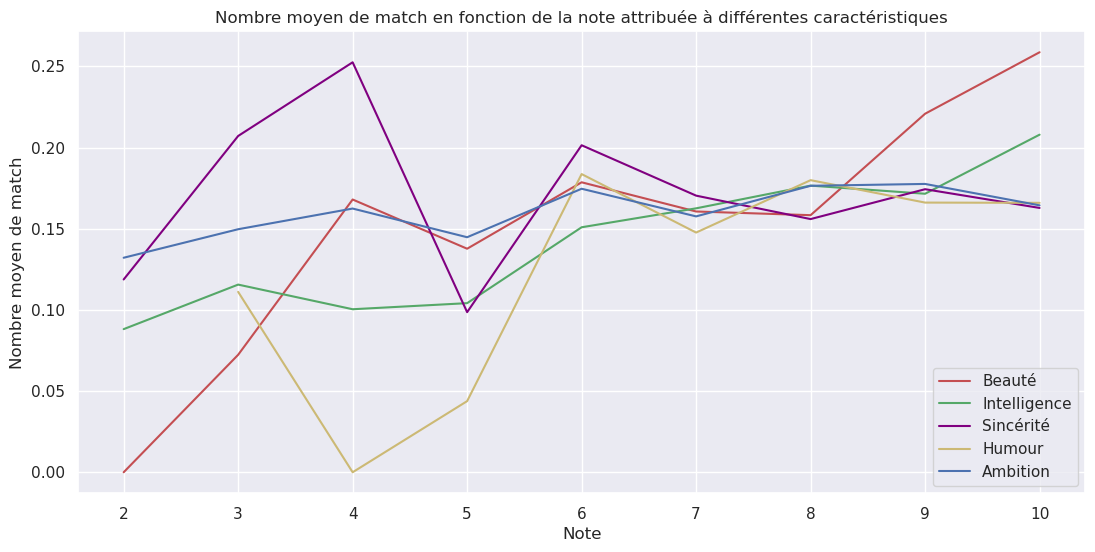

In [27]:
%run "./Graph_Nb_Matchs_1.ipynb"

- De manière générale, on constate que pour la beauté et l'humour, les valeurs extrémales sont très importantes : les personnes très belles ont beaucoup plus de match que la moyenne
- On remarque aussi que les personnes les moins belles et les moins drôles ont beaucoup moins de match que la moyenne, alors que pour l'intelligence, la sincérité et l'ambition, les valeurs sont beaucoup plus homogènes, et ces critères semblent avoir moins d'influence

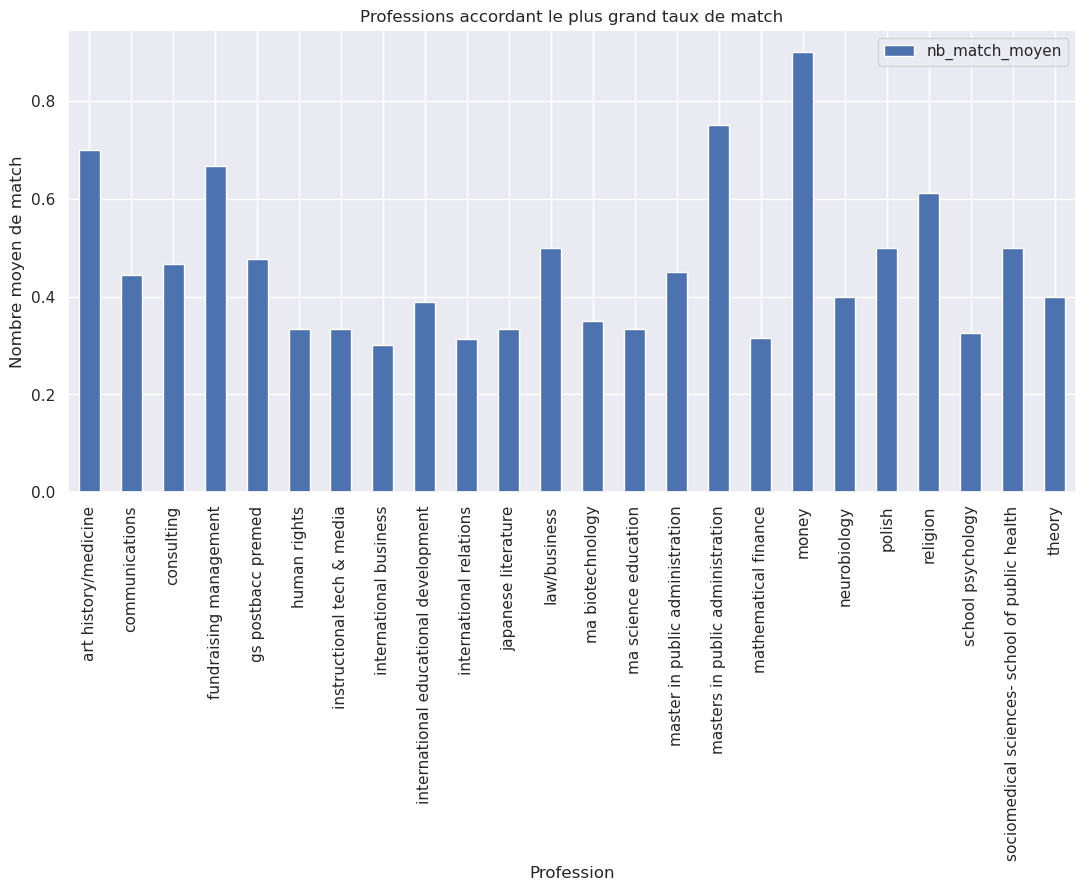

In [28]:
%run "./Graph_Nb_Matchs_2.ipynb"

Cet histogramme nous donne le nombre moyen de match par personne en fonction du métier que la personne en question exerce.
- On remarque dans un premier temps qu'un grand nombre de professions amène à une probabilité de matcher qui se situe à moins de 40% (exactement entre 30% et 40%).
- On remarque que les métiers qui permettent d'obtenir une probabilité de matcher strictement supérieure à $\frac{1}{2}$ ne sont qu'au nombre de 5 : il s'agit des catégories : `art history/medicine` , `fundraising management` , `master in public administration` , `money` , `religion`

#### 2) Analyse sur la probabilité de matcher

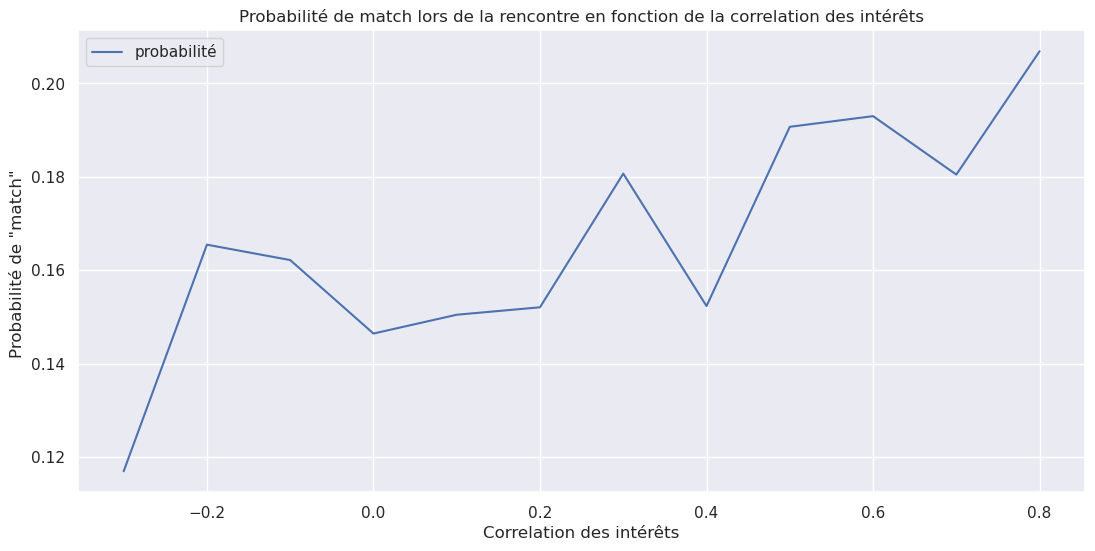

In [32]:
%run "./Graph_Prob_Matchs_1.ipynb"

- Le résultat n'est pas surprenant : on s'attend à avoir une relation croissante entre la corrélation des centres d'intérêts et la probabilité d'obtenir un match
- On remarque aussi que la différence entre n'avoir rien en commun (correlation = 0) et une correlation très forte (= 0.8) fait passer la probabilité de match de 0.15 à 0.21, soit la même différence entre obtenir la note de 4 en beauté et la note de 9 selon le tout premier graphique

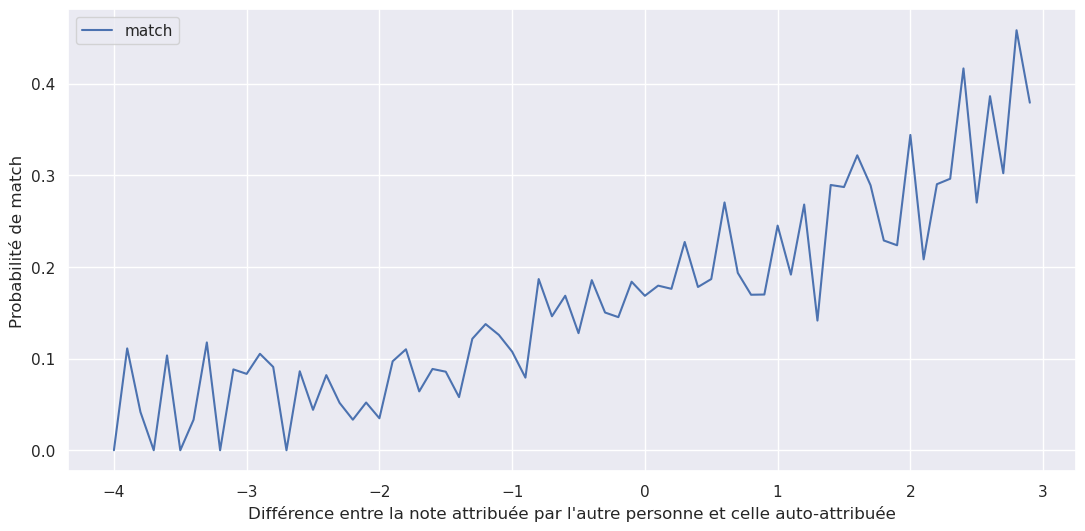

In [33]:
%run "./Graph_Prob_Matchs_2.ipynb"

- On obtient un résultat intéressant et moins évident qu'il peut paraître : si je me mets une note de 9 et que la fille dit que je suis un 8, certes elle m'a donné une note "élevée" dans l'absolu, ce qui prédit un match mais la différence entre les notes est de $-1$ et on voit  qu' ici, la probabilité de matcher est de 0.1. 
- De manière générale, il semble y avoir une relation croissante entre "l'humilité" (caractérisé par l'écart positif entre la note reçue par le partenaire et la note qu'on s'attribue soi-même) et la probabilité de matcher.
- Ainsi, les personnes avec plus "d'ego", *i.e*, s'attribuant des notes élevées si bien qu'il y a un écart avec la note attribuée par le partenaire, réalisent moins de matchs.

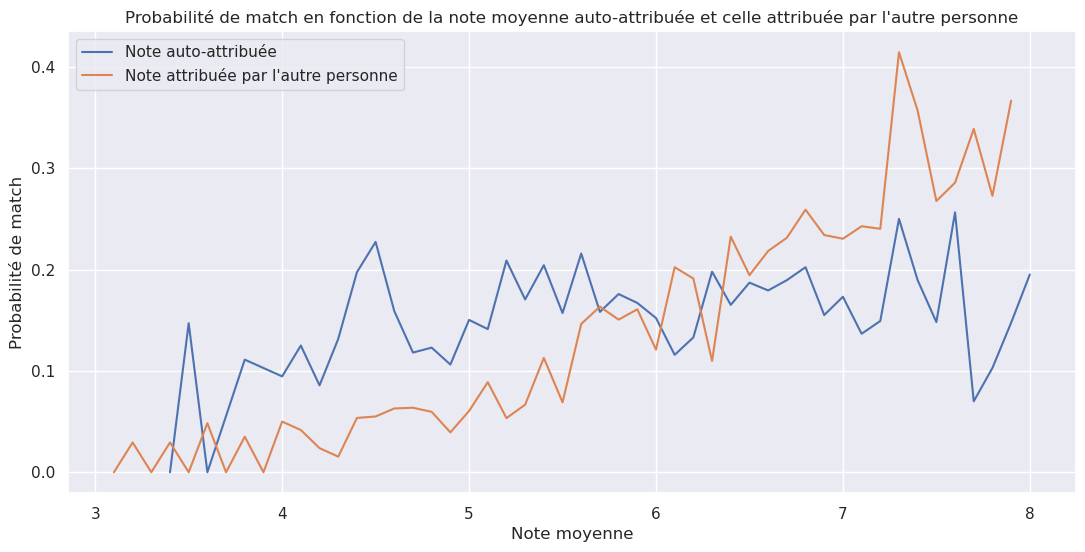

In [34]:
%run "./Graph_Prob_Matchs_3.ipynb"

Ces résultats ne sont pas surprenants : 
- Globalement, on observe une constance dans le fait de matcher en fonction de la note moyenne auto-attribuée
- Globalement, on observe aussi qu'il y a une relation croissante entre la note moyenne reçue par le partenaire et la probabilité de matcher
- Non seulement, on peut confirmer cette relation de croissance que l'on supposait déjà entre la note reçue et la probabilité de matcher mais on peut aussi en déduire que l'impact de la note auto-attribuée dans la probabilité de matcher est moindre par rapport à celui de la note reçue (ce qui semble cohérent)

#### 3) Distribution des intérêts par rapport à la probabilité des matchs

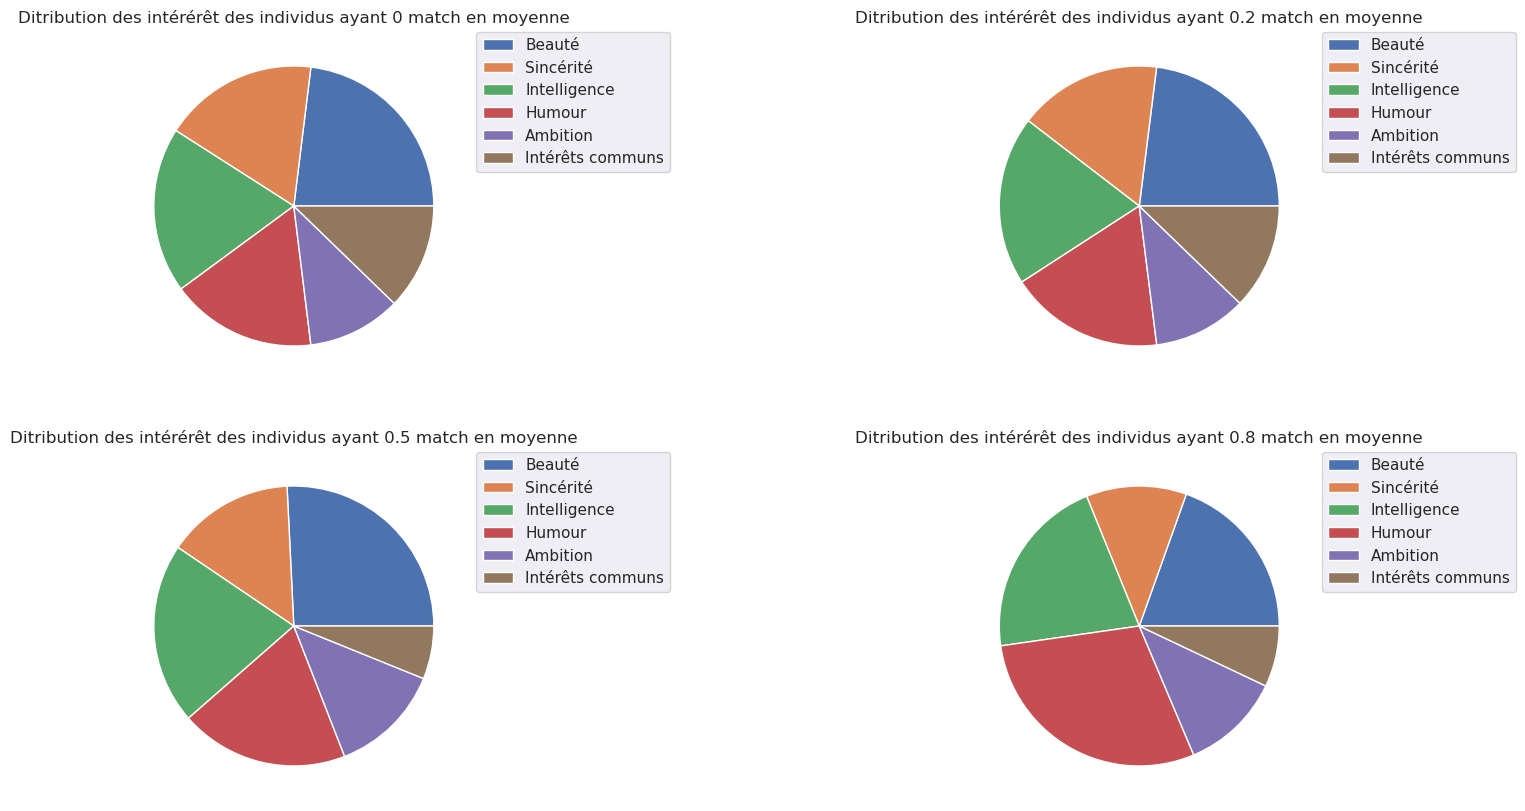

In [35]:
%run "./Graph_Dis_Int.ipynb"

On constate pas mal de choses : 
- L'humour devient de plus en plus important quand on a de plus en plus de match 
- Les intérêts en commun et la sincérité sont au contraire de moins en moins important. 
- L'ambition et la sincérité semblent être des paramètres constants au fur et à mesure que la probabilité de matcher augmente
- Enfin on remarque que la beauté physique (l'attractivité) reste le paramètre le plus important pour pouvoir réaliser à peu près un match sur deux, cependant, on remarque que c'est toujours un paramètre important dans les probabilités très élevées mais qu'il est moins considéré que l'humour ou l'intelligence
- On peut supposer qu'à partir d'une certaine probabilité de matcher assez élevée, seuls des individus ayant une beauté physique assez élevée sont concernés et donc que ce paramètre ne constitue plus une "valeur ajoutée".

### b) Quelques différences entre les sexes

#### Analyse des notations des activités

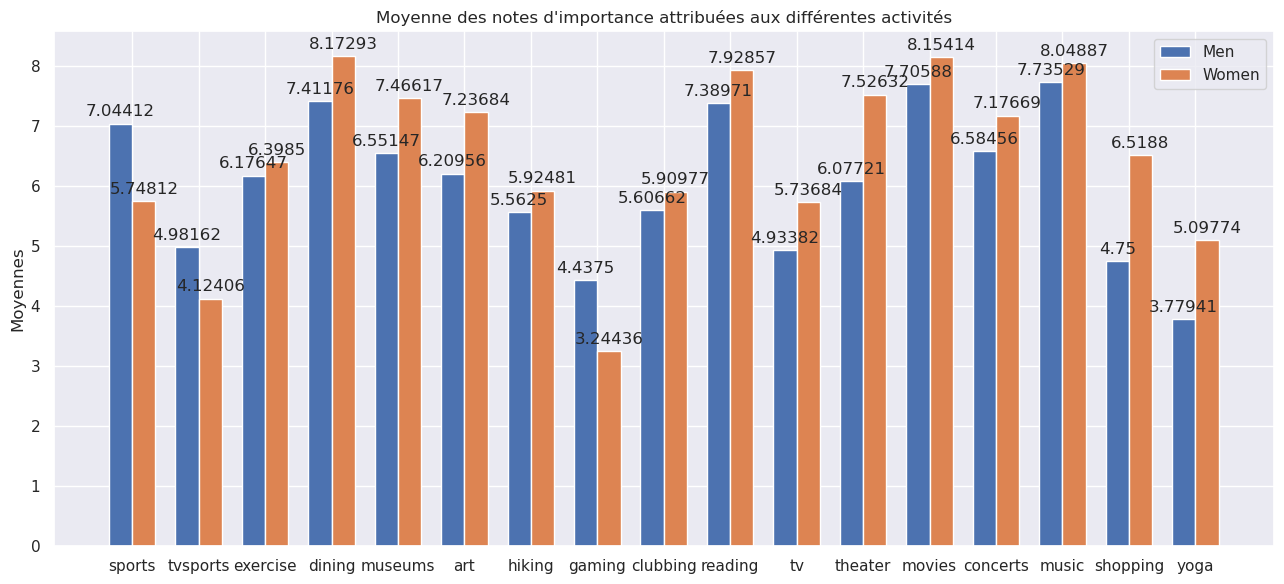

In [36]:
%run "./Hist_Activites_Gen.ipynb"

- Dans un premier temps, on remarque que les femmes mettent des meilleures notes que les hommes sur la majorité des activités, sauf : le sport, le sport télévisé, et les jeux vidéos.
- Dans une grande majorité, l'écart de note entre les hommes et les femmes est aux alentours d'un point (ou moins)
- Les activités où il semble y avoir le plus d'écart sont : les sports, les jeux vidéos, le yoga et le shopping 
- A part les sports, ces trois dernières activités sont globalement les moins bien notées, creusent le plus l'écart et on pourrait supposer qu'elles soient aussi très discriminantes ou au contraire qu'elles jouent un rôle important de par leur spécificité

#### Analyse des notations propres

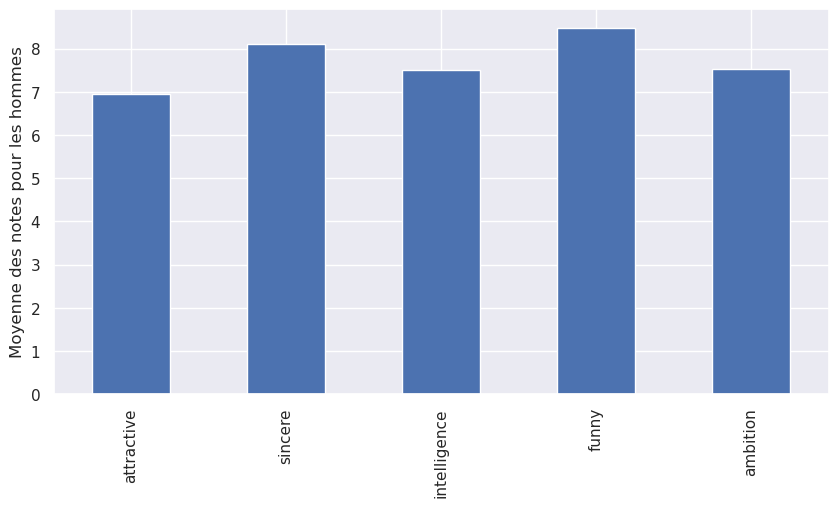

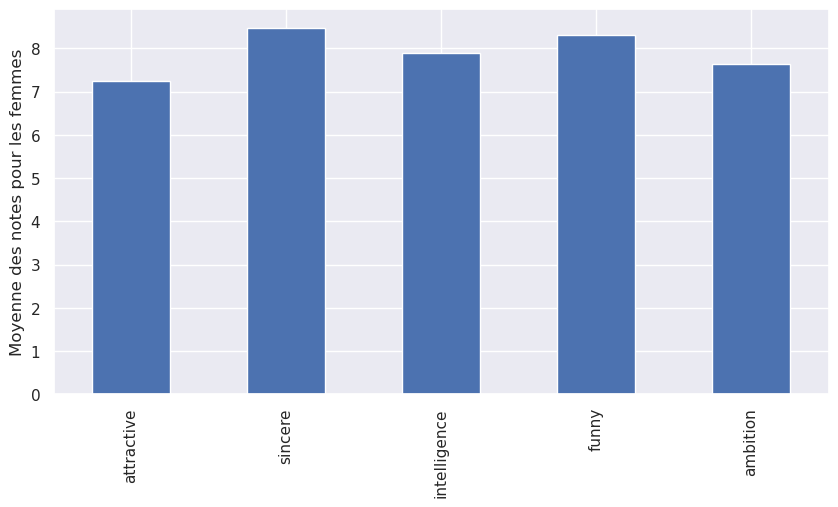

In [37]:
%run "./Hist_Car_Propre.ipynb"

 - On constate qu'en moyenne, les hommes et les femmes se notent de la même manière en considérant leur aspect fun et leur aspect sincère légèrement plus au-dessus que les trois autres caractéristiques. 
 - Il n'y a pas de différence notable à tirer de ces histogrammes
 - La conclusion qu'on peut tirer est que de manière générale la perception qu'on les hommes d'eux mêmes ne diffère pas de la perception que les femmes ont d'elles mêmes

## IV - Poids de certaines caractéristiques sur la décision finale

Dans cette partie, nous voulions étudier l'impact des différentes variables sur la variable `decision_o` : c'est à dire sur la décision finale du partenaire. Ainsi, notre variable d'intérêt est la variable `decision_o` et toutes les autres sont des paramètres sur lesquels il peut être intéressant de régresser `decision_o`. Il faut garder en tête que la variable `decision_o` est une variable binaire et donc qu'il faut faire attention au choix de la régression. Nous avons donc choisi dans cette partie de réaliser des régressions logistiques par soucis de précision. En effet, on prouve plus tard que la précision que nous obtenons en réalisant des régressions logistiques est bien plus élevée que celle en réalisant une régression linéaire classique (même si bien sûr elle peut encore être améliorée).

#### 1) Régression logistique de `decision_o` sur les caractéristiques fixes dans la population totale

précision de la régression logistique: 58.938139308329276
précision de la régression linéaire: 3.0949201494899548


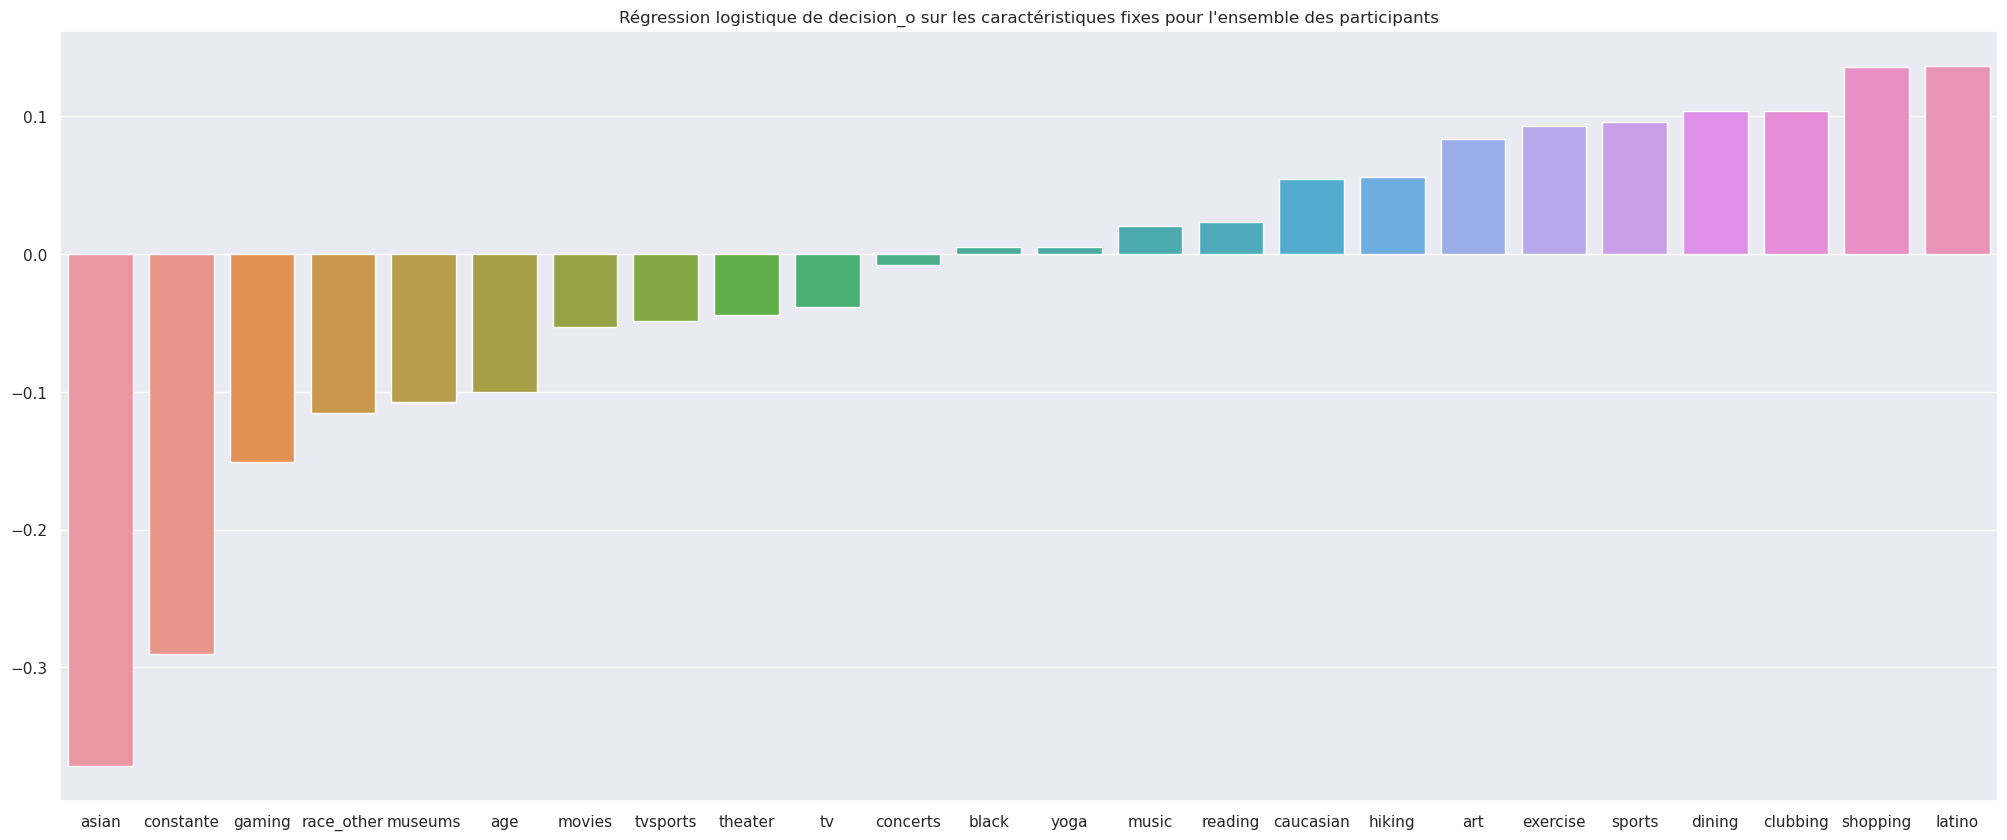

In [38]:
%run "./Reg_Log_1.ipynb"

La première régression logistique permet de donner l'impact des différentes caractéristiques fixes (activités et origine) sur la décision du partenaire.
- Dans un premier temps, on observe qu'il y a à peu près autant qui ont un impact négatif que de caractéristiques qui ont un impact positif.
- La caractéristique la plus surprenante est l'origine asiatique : en effet, son coefficient dans la régression logistique est le plus faible (quasiment -0.4 : toute chose égale par ailleurs, le simple fait d'être asiatique diminue les chances que le partenaire prenne une décision positive de 40%). On pourrait penser à un biais de sélection comme une sous-représentation de la population asiatique dans notre échantillon mais en réalité, l'échantillon est constitué de 24% d'asiatiques donc on rejette cette hypothèse.
- On observe aussi que le coefficient de la musique est positif mais proche de 0 : c'est cohérent car on a vu que la musique est une des activités les plus appréciées par l'ensemble de l'échantillon donc s'y intéresser ne peut pas être négatif mais ça n'en fait pas non plus une valeur ajoutée
- Le coefficient de l'âge est négatif : ceci peut se comprendre avec le fait que cette application concerne une population essentiellement jeune (26 ans en moyenne)
- De manière générale, les activités qui semblent rapporter des points sont : l'art, l'exercice, le sport, le shopping, le clubbing et le fait d'aller à des dîners
- Enfin, les caractéristiques qui semblent avoir un impact négatif sur la décision finale sont : la tv, le théâtre, le sport télévisé, les films et les jeux vidéos


#### 2) Comparaison entre hommes et femmes

##### a) Régression logistique de `decision_o` des femmes sur les caractéristiques des hommes

précision de la régression logistique: 62.76595744680851


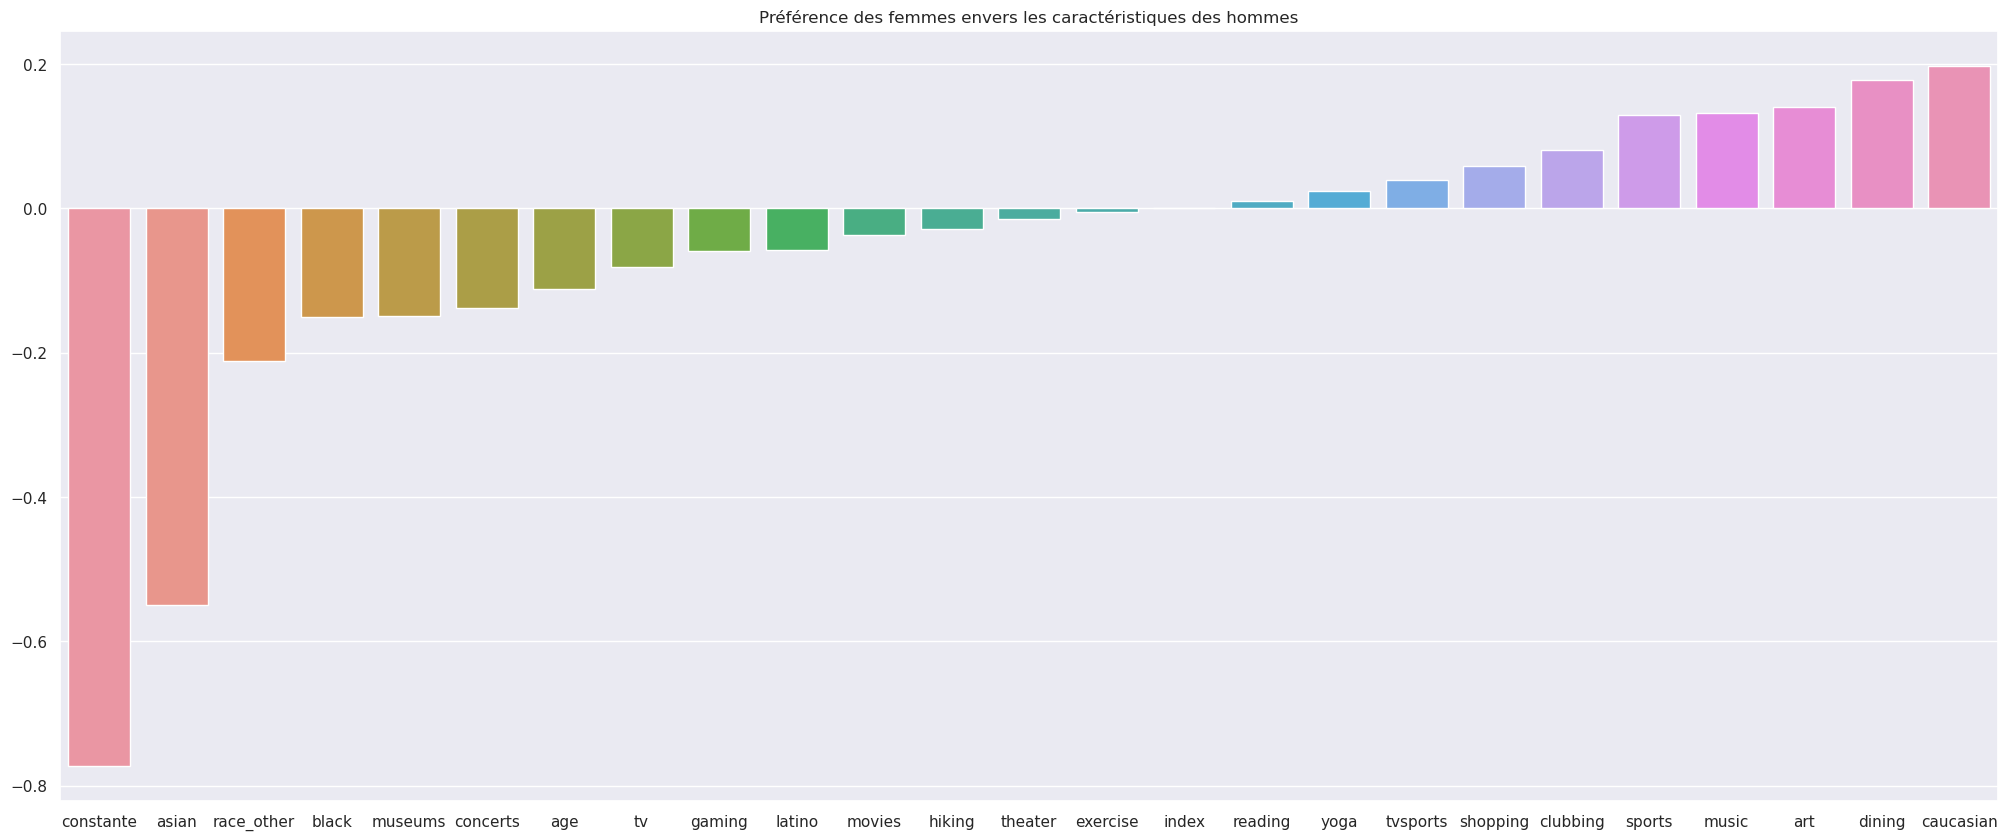

In [39]:
%run "./Reg_Log_2.ipynb"

Cette deuxième régression logistique permet toujours de donner l'impact des différentes caractéristiques fixes (activités et origine) sur la décision du partenaire. Mais cette fois-ci, on s'intéresse aux caractéristiques des hommes qui impactent la décision des femmes.
- Le centre est légèrement décalé sur la droite : on a 3 caractéristiques de plus qui impactent la décision des femmes négativement
- Le coefficient le plus bas est la constante : quasiment -0.8
- Le coefficient le plus haut est l'origine européenne/caucasienne : 0.2
- Les activités que les femmes semblent les plus apprécier chez les hommes sont : les dîners, l'art, la musique et le sport mais aussi légèrement le clubbing, le shopping, les sports télévisés, le yoga et la lecture
- Les activités que les femmes semblent les moins apprécier chez les hommes sont : les musées, les concerts, la tv, les jeux vidéos, le hiking, les films, le théâtre et l'exercice.
- On observe toujours un fort coefficient négatif du côté des asiatiques mais aussi un coefficient négatif auprès des afro-américains et des types "autres". 

##### b) Régression logistique de `decision_o` des hommes sur les caractéristiques des femmes

précision de la régression logistique: 57.801766437684


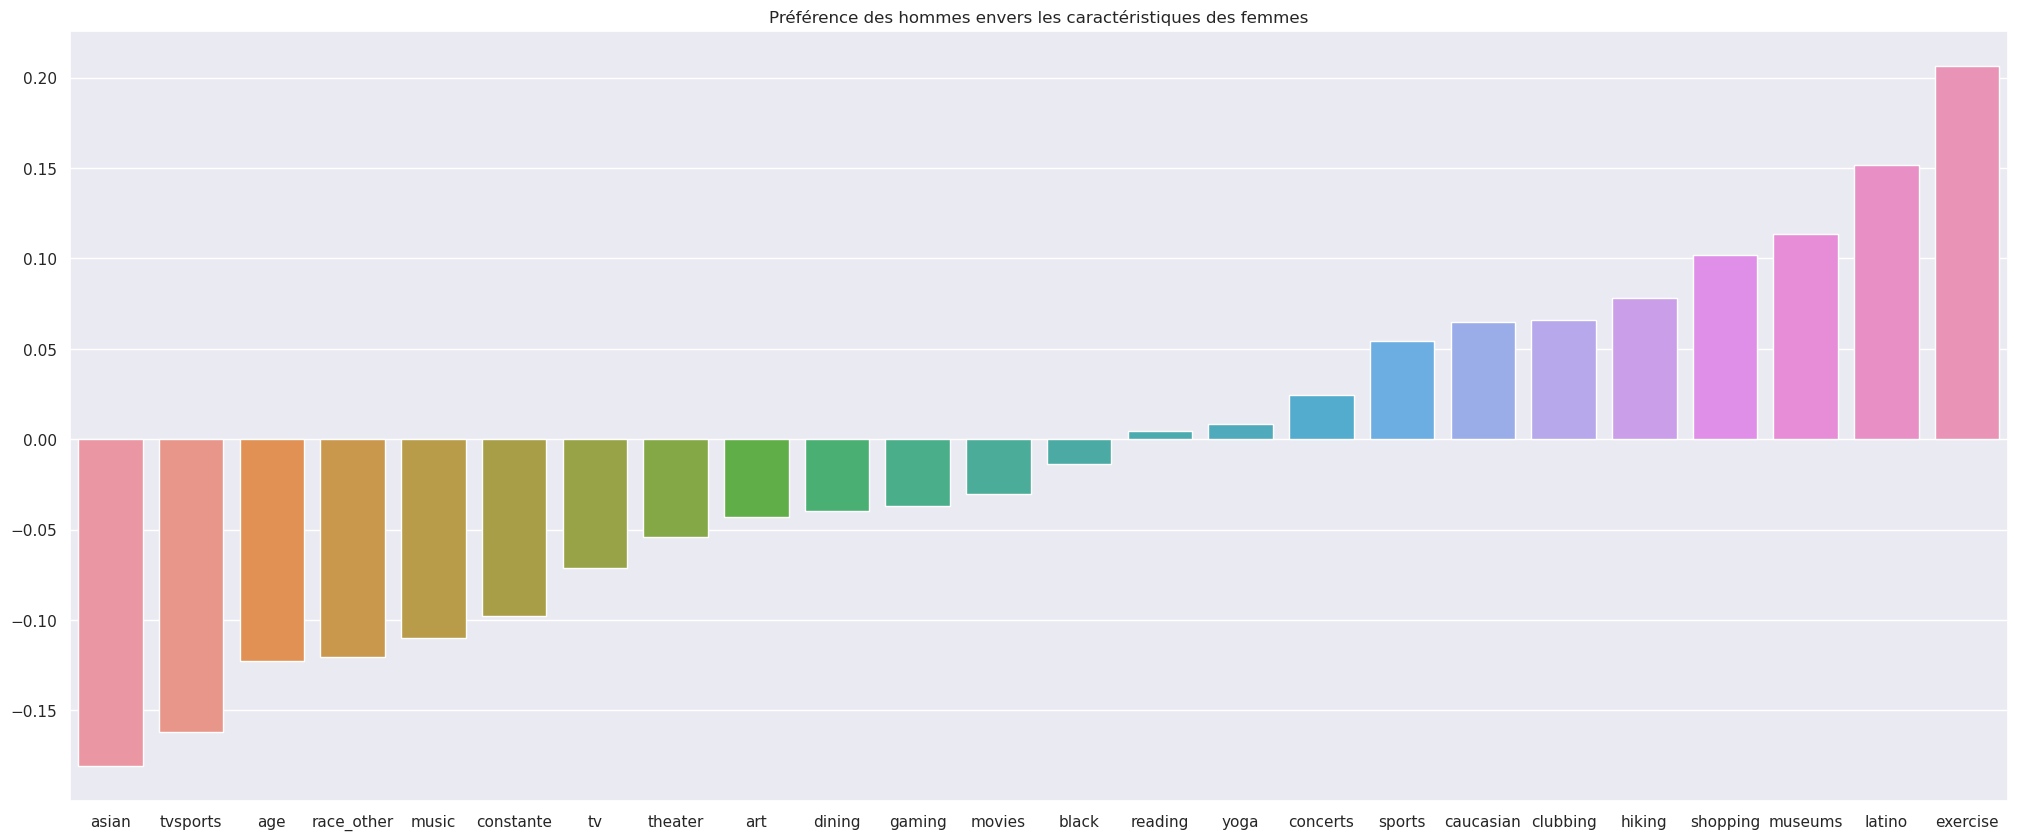

In [40]:
%run "./Reg_Log_3.ipynb"

Cette troisième régression logistique permet cette fois-ci de quantifier l'impact des différentes caractéristiques fixes (activités et origine) de la femme sur la décision de l'homme.
- On constate que le graphique est plus centré que le précédent (il semble y avoir autant de point positifs que de négatifs)
- La caractéristique qui rapporte le plus de point est le fait de faire de l'exercice (0.2) et celle qui en coûte le plus et celle d'être asiatique (-0.2)
- Dans les activités légèrement appréciées par les hommes chez les femmes, on va retrouver la lecture, le yoga et les concerts.
- Dans les activités appréciées on a : les sports, le clubbing, le hiking, le shopping et les musées
- Les activités les moins appréciées sont : les films, les jeux vidéos, les dîners, l'art, le théâtre, la tv, la musique et les sports télévisés
- Parmi les originies, les latinos et les européens/caucasiens l'emportent sur le reste

##### c) Comparaison

- La première chose frappante lorsqu'on regarde les deux graphiques est le centre : chez les hommes le graphique est centré, il y a autant de caractéristiques positives que de caractéristiques négatives. Alors que chez les femmes, il y a un peu plus de caractéristiques négatives et la valeur absolue de leurs coefficients et bien plus élevées que les caractéristiques positives. Ainsi, on peut en déduire que les femmes sont plus sélectives sur cette plateforme que les hommes et qu'il semble être plus facile de déplaire à une femme que de déplaire à un homme
- Cette hypothèse peut être encore une fois soulignée en comparant les coefficients des constantes dans les deux régressions : la constante vaut -0.15 chez les hommes pour quasiment -0.8 chez la femme qui de plus est le coefficient le plus bas. Ceci confirme notre hypothèse de sélectivité : de base les femmes vont être beaucoup plus sélectives dans leur décision que les hommes et vont donner moins de décisions positives que ces derniers.

#### 3) Régression logistique de `decision_o` sur les notes reçues des 6 critères

Enfin, nous avons décidé de réaliser une régression logistique de la variable `decision_o` sur la note donnée par le partenaire concernant les 6 critères suivants : l'ambition, la sincérité, l'intelligence, le côté fun, les points communs et l'attractivité.

précision de la régression logistique: 74.72463768115942


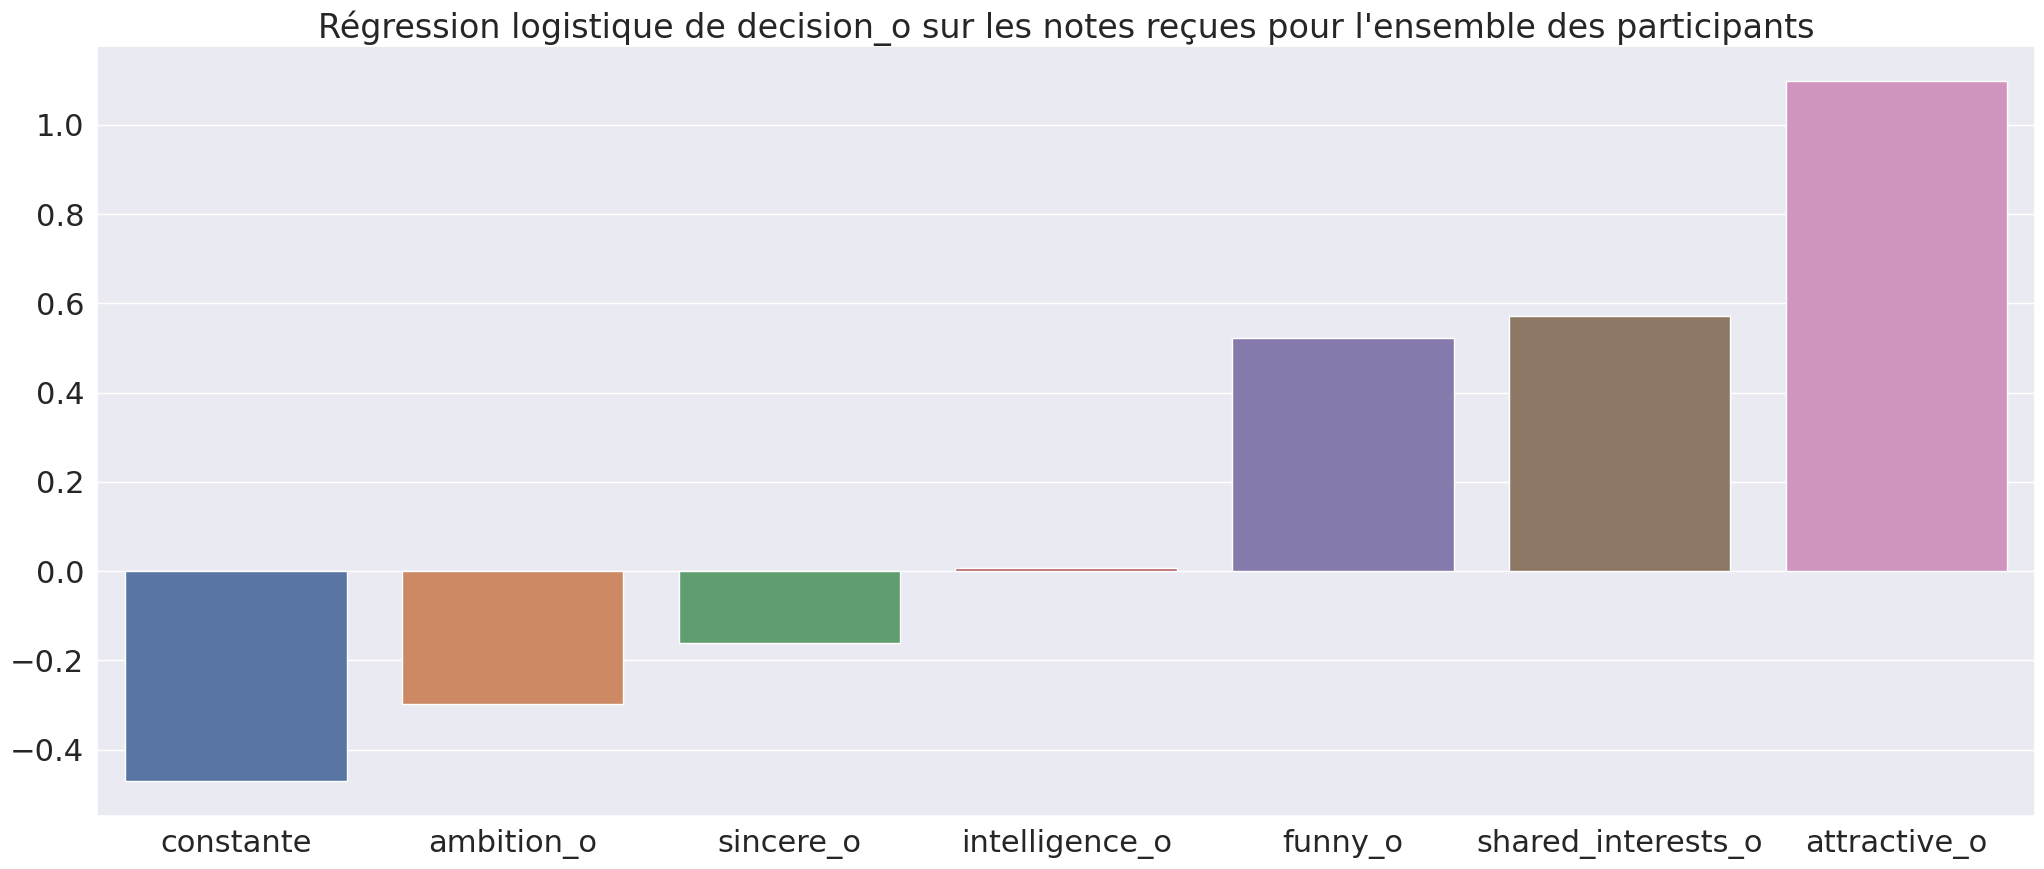

In [41]:
%run "./Reg_Log_4.ipynb"

On trouve que les critères (du plus pénalisant au plus valorisant) sont : l'ambition, la sincérité, l'intelligence, le côté fun, les points communs et l'attractivité.
- les impacts du côté fun, des points communs et de l'attractivité sont positifs alors que ceux de l'ambition et de la sincérité sont négatifs et celui de l'intelligence est nul
- On observe aussi que l'attractivité semble jouer un rôle important dans la décision finale de par son coefficient ectrêmement élevé
- On pourrait trouver surprenant que les coefficients de l'ambition ou de la sincérité soient négatifs car ces caractéristiques semblent être de "bonnes" caractéristiques. Cependant, les 6 caractéristiques sont en réalités de "bonnes qualités". Cependant, dans la mesure où il n'y a pas 100% de réussite et que la décision négative existe, il peut y avoir au moins corrélation entre décision négative et une ou plusieurs de ces caractéristiques (sans pour autant avoir causalité).

## Conclusion générale

### Réponse à la problématique

Ce projet nous a permis conctrètement d'analyser de nombreuses caractéristiques (activités, centres d'intérêts, origines, profession, ...) et leur impact sur la probabilité de "matcher" ou d'au moins obtenir une décision positive de la part du partenaire en face de nous.

Nous nous retrouvons avec des conclusions attendues comme par exemple l'importance de la beauté physique (caractérisée par la variable `attractive` ici. Aussi, nous avons observé que la note concernant les 6 traits de caractère (beauté physique, intelligence, ambition, sincérité, humour, centres d'intérêts communs) semblait avoir une corrélation positive avec la probabilité d'obtenir un "match".

Aussi, nous avons pu, à l'aide des régressions logistiques, établir certaines corrélations qui paraissaient prévisibles et d'autres plus étonnantes comme la corrélation fortement négative entre être asiatique et la probabilité d'obtenir une décision positive du partenaire.

Enfin, nous avons aussi pu analyser quelques différences entre les hommes et les femmes et même si dans les grandes lignes, leurs statistiques sont les mêmes, nous pouvons constater que les femmes semblent être plus sélectives et donnent plus de décisions négatives que les hommes sur cette plateforme.

Bien sûr, nous gardons en tête que notre étude a été réalisée à partir d'une base de données extraites d'une plateforme de speed dating dans les années 2000 et que notre échantillon reste restreint et n'a que peu de choses à voir avec les applications de rencontre d'aujourd'hui. Cependant, nous pouvons quand même nous réjouir des nombreuses observations que nous avons pu réaliser lors de ce projet et espérons qu'un jour, nous pourrons les étendre sur des bases de données plus grandes, plus récentes et plus actuelles.

### Conclusions personnelles

- Même si notre groupe aurait aimé travailler sur une application de rencontre (comme Tinder, Lovoo, Fruitz etc...) nous étions dans l'incapacité de nous procurer un jeu de données intéressant sur lequel il était possible d'en faire tout un projet. Ainsi, nous avons dû travailler avec cette base de données (extraite d'une plateforme réalisant des speed datings dans les années 2000) pour pouvoir rester dans un thème qui nous intéressait tout en produisant quelque chose de viable.
- Ce projet nous a permis de mettre en pratique de nombreuses connaissances sur Git et Pandas que nous avions vues en cours mais nous a aussi mis face à de nombreuses difficultés techniques rencontrées notemment lors de la phase d'obtention d'une sous-base de données propre.
- Une des limites de ce projet concerne les régressions logistiques. Bien sûr, celles-ci étaient nécessaires ici car bien plus précises que les régressions linéaires, cependant, avec une précision autour des 60%, nous imaginons qu'il est possible d'avoir des modèles bien plus précis si nous avions des connaissances supplémentaires en machine learning.